In [1]:
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/TrafficSignData')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/TrafficSignData


In [2]:
# clone dataset
#!git clone https://bitbucket.org/jadslim/german-traffic-signs
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
# import all necessary library

In [33]:

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2
import tensorflow as tf

In [4]:
#from keras.callbacks import LearningRateScheduler, ModelCheckpoint
 
%matplotlib inline
np.random.seed(0)

In [5]:
# TODO: Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
 

In [6]:
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [7]:
#already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [8]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

In [9]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

In [10]:
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

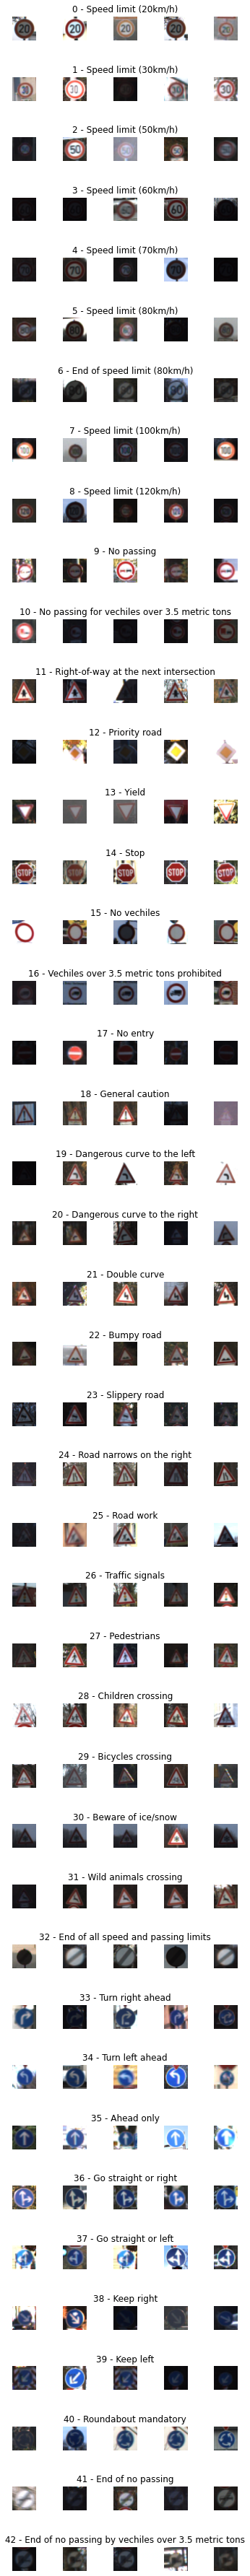

In [11]:
num_of_samples=[]
 
cols = 5
num_classes = 43
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    #print(row['ClassId'],row['SignName'])
    x_selected = X_train[y_train==j]
    #print(j,row['SignName'] , x_selected.shape)
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    #print(x_selected.shape)
    if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


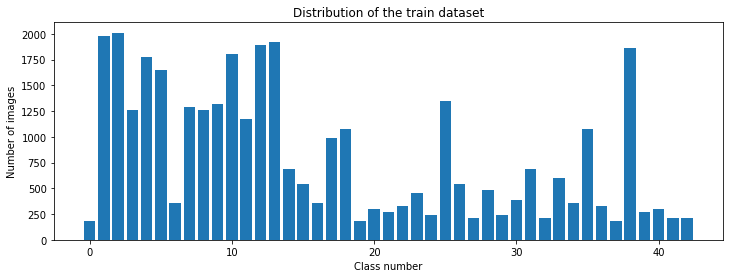

In [12]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


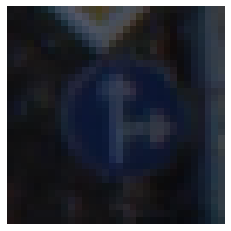

In [13]:
import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

In [14]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


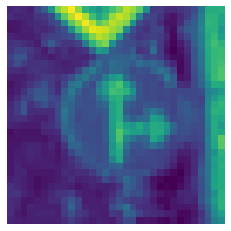

In [15]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [16]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


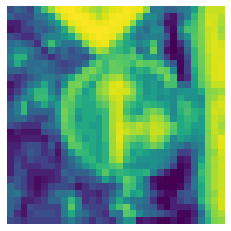

In [17]:
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [18]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

(34799, 32, 32)


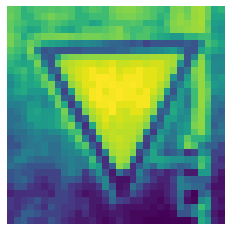

In [19]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [20]:
# reshape
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [21]:
# preprocessing image for augementation
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)

(15, 32, 32, 1)


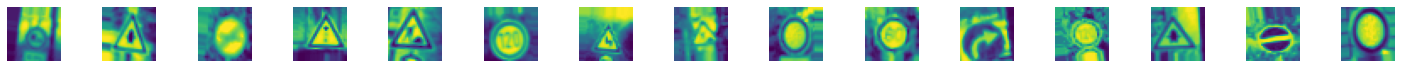

In [22]:
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [23]:
# no labeling the image
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [24]:
# create model
 
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [25]:
model = modified_model()
print(model.summary())
 
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                           # steps_per_epoch=len(X_train)// 50,
                            epochs=20,
                            validation_data=(X_val, y_val), shuffle = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

Text(0.5, 0, 'epoch')

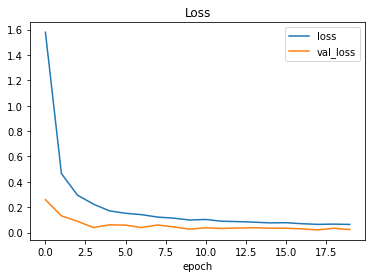

In [26]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('Loss')
plt.xlabel('epoch')


Text(0.5, 0, 'epoch')

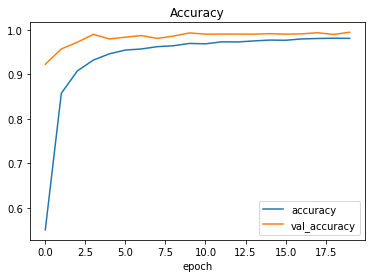

In [27]:
 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [28]:
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.13800717890262604
Test accuracy: 0.9695170521736145


In [29]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [30]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 

Loaded model from disk


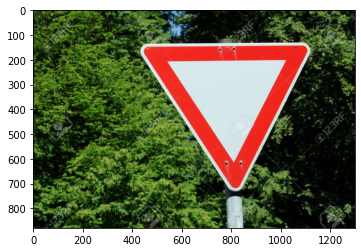

In [116]:
#predict internet number
import requests
from PIL import Image
#url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg' -> output : 34
#url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg' # 1
#rl = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg' # 23
#url ='https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg' # output : 29
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg' # output : 13
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))



(32, 32)
predicted sign: 13
(1, 32, 32, 1)
prediction name: Yield


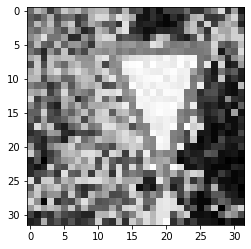

In [117]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
prediction = loaded_model.predict(img)
prediction = np.argmax(prediction)
print("predicted sign: "+ str(prediction))
print(img.shape)
if prediction in data["ClassId"]:
   SignName = data["SignName"][prediction]
   print('prediction name: '+ SignName )

In [39]:
# tensorflow lite to savedModel
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp2z_h9av0/assets


INFO:tensorflow:Assets written to: /tmp/tmp2z_h9av0/assets


[{'name': 'serving_default_conv2d_input:0', 'index': 0, 'shape': array([ 1, 32, 32,  1], dtype=int32), 'shape_signature': array([-1, 32, 32,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
== Input details ==
shape: [ 1 32 32  1]
type: <class 'numpy.float32'>

== Output details ==
shape: [ 1 43]
type: <class 'numpy.float32'>
== Input details ==
shape: [ 1 32 32  1]

== Output details ==
shape: [ 1 43]
Prediction results shape: (1, 43)
prediction name: Yield
13


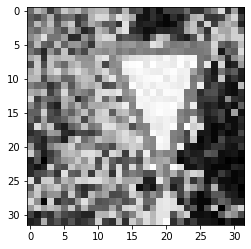

In [125]:
# source : https://thinkmobile.dev/testing-tensorflow-lite-image-classification-model/
import cv2
#predict internet number
import requests
from PIL import Image
#url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg' -> output : 34
#url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg' # 1
#rl = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg' # 23
#url ='https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg' # output : 29
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg' # output : 13
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
img = img.reshape(1, 32, 32, 1)


# load the tensorflow lite model and get the output
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])


# resize the image
interpreter.resize_tensor_input(input_details[0]['index'], (1, 32, 32, 1))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 43))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])

input_shape = input_details[0]['shape']
input_data = np.array(img, dtype=np.float32)
# Set batch of images into input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)
# Run inference
interpreter.invoke()
# Get prediction results
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data = np.argmax(output_data)

if output_data in data["ClassId"]:
   SignName = data["SignName"][output_data]
   print('prediction name: '+ SignName )
print(output_data)